# Practice Lab 18: Convolutional Neural Networks
In this lab we will look at how Convolutional Neural Networks for classification and regression. \
Based on Chapter 14 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\
Original code examples from book in github [here](https://github.com/ageron/handson-ml2)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice18a_CNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Add for GPU BEFORE JSON
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
####################################

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

2022-11-15 08:36:49.246010: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 08:36:55.433153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10237 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
2022-11-15 08:36:55.484715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5886 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5


Added two functions for plotting

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Exercise 1: CNN dimensions
In this first exercise we want to get familiar with dimensions.\
Load the two images below and apply a vertical and a horizontal filter.\
Check all dimensions. Then plot one row of one of the figures before and after convolutions. \
Show how the convolution with the horizontal filter produces a smoothing along the rows.

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
print("batch_size, height, width, channels",images.shape)
batch_size, height, width, channels = images.shape
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
print(filters.shape)

batch_size, height, width, channels (2, 427, 640, 3)
(7, 7, 3, 2)


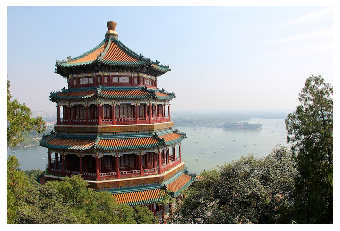

In [4]:
plot_image(china)

In [5]:
print(china.shape)

(427, 640, 3)


In [6]:
print(flower.shape)

(427, 640, 3)


Text(0.5, 1.0, 'column')

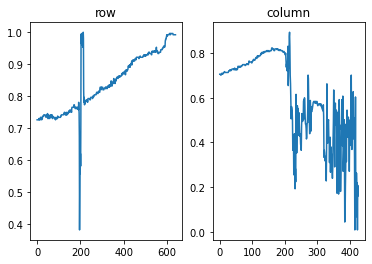

In [7]:
# show a row and a column of the original picture
plt.subplot(121);plt.plot(china[50,:,0]);plt.title('row')
plt.subplot(122);plt.plot(china[:,50,0]);plt.title('column')

In [8]:
print(images.shape)

(2, 427, 640, 3)


In [9]:
print(filters.shape)

(7, 7, 3, 2)


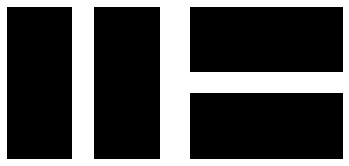

In [10]:
plt.subplot(121);plot_image(filters[:,:,:,0])
plt.subplot(122);plot_image(filters[:,:,:,1])

We can perform the correlations using conv2d. We see 3 input features map to 2 output features because we have 2 filters. \
What do these operations represent? What does multiplication by a boxcar represent?

In [11]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

2022-11-15 08:52:54.901874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10237 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
2022-11-15 08:52:54.902315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5886 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5
2022-11-15 08:53:00.152127: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


In [12]:
print(outputs.shape)

(2, 427, 640, 2)


In [13]:
print(images.shape)

(2, 427, 640, 3)


In [14]:
print(filters.shape)

(7, 7, 3, 2)


What do we get if we print index 0 and 1 in the first index?\
What do we get if we print index 0 and 1 in the last index?

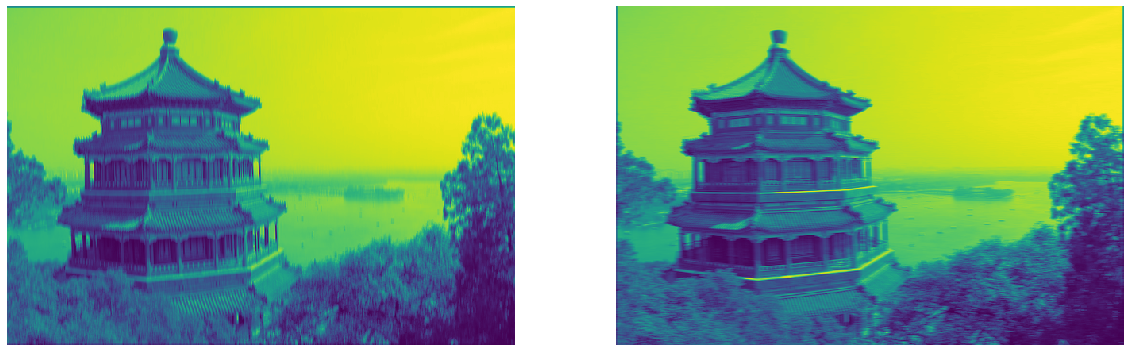

In [15]:
plt.figure(figsize=(20,20))
plt.subplot(121),plot_color_image(outputs[0,:,:,0])
plt.subplot(122),plot_color_image(outputs[0,:,:,1]);

What do we get if we choose one index on the second or third indexes?

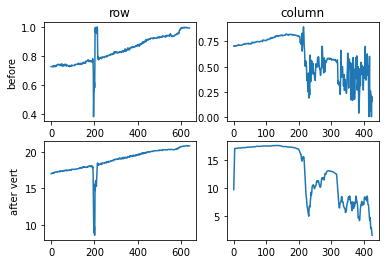

In [16]:
# plot a row and a column before and after the vertical filter
plt.subplot(221);plt.plot(images[0,50,:,0]);plt.title('row');plt.ylabel('before')
plt.subplot(222);plt.plot(images[0,:,50,0]);plt.title('column')
plt.subplot(223);plt.plot(outputs[0,50,:,0]);plt.ylabel('after vert')
plt.subplot(224);plt.plot(outputs[0,:,50,0]);

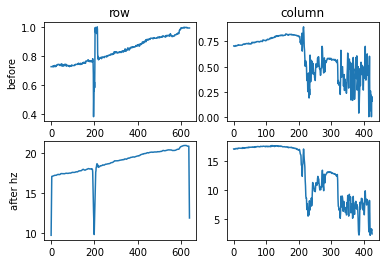

In [17]:
# plot a row and a column after the horizontal filter

plt.subplot(221);plt.plot(images[0,50,:,0]);plt.title('row');plt.ylabel('before')
plt.subplot(222);plt.plot(images[0,:,50,0]);plt.title('column')
plt.subplot(223);plt.plot(outputs[0,50,:,1]);plt.ylabel('after hz')
plt.subplot(224);plt.plot(outputs[0,:,50,1])

Let us see the input (3 layers R, G, B)

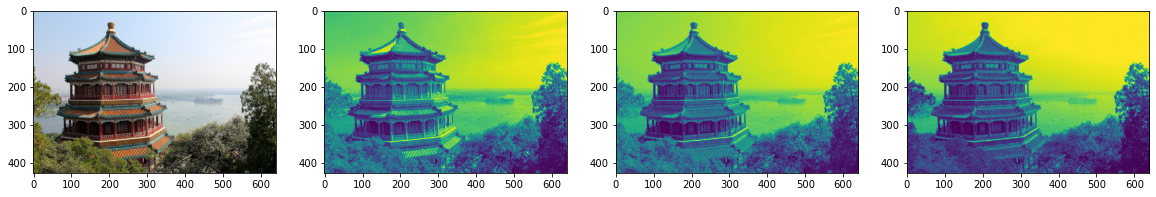

In [18]:
plt.figure(figsize=(20,20))
plt.subplot(141),plt.imshow(images[0])
for i in range(3):    
    plt.subplot(142+i);plt.imshow(china[:,:,i]);

Let us see the output (2 feature maps)

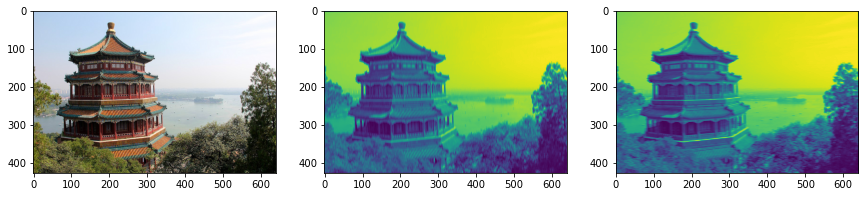

In [19]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.figure(figsize=(20,20))
plt.subplot(141),plt.imshow(images[0])
for i in range(2):    
    plt.subplot(142+i);plt.imshow(outputs[0,:,:,i]);

Applying a pooling layer reduces the dimensions. This allows us to look at patterns with different resolution.

<class 'keras.layers.pooling.MaxPooling2D'>
(2, 427, 640, 2)
(2, 53, 80, 2)


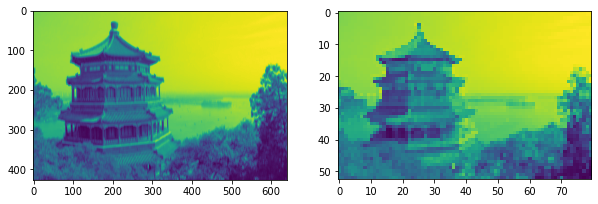

In [20]:
max_pool = keras.layers.MaxPool2D(pool_size=8)
outputspool=max_pool(outputs)
print(type(max_pool))
print(outputs.shape)
print(outputspool.shape)
plt.figure(figsize=(10,10))
plt.subplot(121);plt.imshow(outputs[0,:,:,0])
plt.subplot(122);plt.imshow(outputspool[0,:,:,0]);

## Exercise 2: CNN vs Dense NN
MNIST Classification: Write conv2d for the mnist data set and compare with the 1D neural network we did in a previous lab.\
To treat each digit as an image, you need to add the feature axis, 1 in this case because it is black-white image.

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
# we will need a new axis to represent the channel index (one in this case)
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [22]:
print(X_train.shape)

(55000, 28, 28, 1)


In [23]:
print(X_valid.shape)
print(X_test.shape)

(5000, 28, 28, 1)
(10000, 28, 28, 1)


Let us write a first CNN using the tools we learned above. Notice that each layer needs:
- Number of features (these are like neurons, like Dense NN)
- A kernel_size
- Activation function (like Dense NN)
- Padding strategy
- Pooling layer

Also, notice that:
- after the CNN there will be a **second stage** with a **dense NN**.
- The number of features in the CNN increases as the resolution decreases, 
- The number of neurons in the DNN decreases as we approach the output.

In [25]:
model=keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=(7,7), activation='relu', padding='SAME',input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, kernel_size=(5,5), activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')    
])

Alternatively, for long stacks of layers, we can create a default so we don't need to repeat parameters

In [26]:
#create a default layer to avoid repeating
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu',padding='SAME')

In [27]:
model=keras.models.Sequential([
    DefaultConv2D(64, kernel_size=(7,7), input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(),
    DefaultConv2D(128, kernel_size=(5,5)),
    keras.layers.MaxPooling2D(),
    DefaultConv2D(256),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')    
])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

Compilation and training is done in the same way as Dense NN

In [29]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='SGD',metrics=["accuracy"])

In [31]:
history=model.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0507 - accuracy: 0.9869 - val_loss: 0.0354 - val_accuracy: 0.9932
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0489 - accuracy: 0.9879 - val_loss: 0.0343 - val_accuracy: 0.9918
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0408 - accuracy: 0.9894 - val_loss: 0.0336 - val_accuracy: 0.9930
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0347 - accuracy: 0.9910 - val_loss: 0.0353 - val_accuracy: 0.9930
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0353 - accuracy: 0.9909 - val_loss: 0.0355 - val_accuracy: 0.9926
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0319 - accuracy: 0.9913 - val_loss: 0.0376 - val_accuracy: 0.9916
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0297 - accuracy: 0.9929 - val_loss: 0.0366 - val_accuracy:

In [32]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 354.8106 - accuracy: 0.9920


[354.8106384277344, 0.9919999837875366]

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

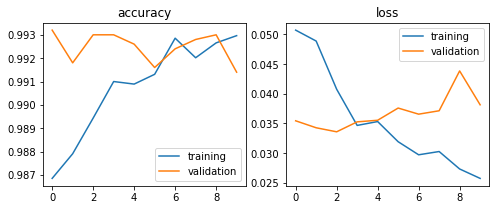

In [34]:
plt.figure(figsize=(8,3))
plt.subplot(121),plt.plot(history.history['accuracy'],label='training');plt.plot(history.history['val_accuracy'],label='validation');plt.title('accuracy')
plt.legend()
plt.subplot(122),plt.plot(history.history['loss'],label='training');plt.plot(history.history['val_loss'],label='validation');plt.title('loss')
plt.legend()

### CNN vs Dense network (FCN)
Now let us compare with the dense network we have been doing before

In [37]:
model1d = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal",activation="relu"),
    keras.layers.Dense(100, kernel_initializer="he_normal",activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model1d.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [38]:
model1d.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [39]:
print(X_train[:,:,:,0].shape)
print(y_train.shape)

(55000, 28, 28)
(55000,)


In [40]:
history1d=model1d.fit(X_train[:,:,:,0],y_train,epochs=10,validation_data=(X_valid[:,:,:,0],y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.1903 - accuracy: 0.6629 - val_loss: 0.5769 - val_accuracy: 0.8568
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5327 - accuracy: 0.8577 - val_loss: 0.3809 - val_accuracy: 0.9016
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4021 - accuracy: 0.8871 - val_loss: 0.3102 - val_accuracy: 0.9176
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3396 - accuracy: 0.9026 - val_loss: 0.2733 - val_accuracy: 0.9286
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3006 - accuracy: 0.9134 - val_loss: 0.2489 - val_accuracy: 0.9328
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2732 - accuracy: 0.9206 - val_loss: 0.2318 - val_accuracy: 0.9382
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2521 - accuracy: 0.9259 - val_loss: 0.2195 - val_accuracy:

In [41]:
model1d.evaluate(X_test[:,:,:,0],y_test)

313/313 [==============================] - 1s 2ms/step - loss: 3939.7524 - accuracy: 0.9362


[3939.75244140625, 0.9362000226974487]

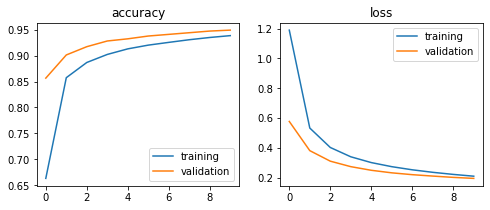

In [42]:
plt.figure(figsize=(8,3))
plt.subplot(121),plt.plot(history1d.history['accuracy'],label='training');plt.plot(history1d.history['val_accuracy'],label='validation');plt.title('accuracy')
plt.legend()
plt.subplot(122),plt.plot(history1d.history['loss'],label='training');plt.plot(history1d.history['val_loss'],label='validation');plt.title('loss')
plt.legend();

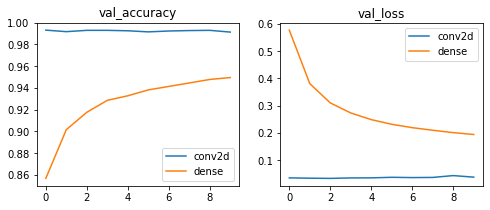

In [43]:
plt.figure(figsize=(8,3))
plt.subplot(121),plt.plot(history.history['val_accuracy'],label='conv2d');plt.plot(history1d.history['val_accuracy'],label='dense');plt.title('val_accuracy')
plt.legend()
plt.subplot(122),plt.plot(history.history['val_loss'],label='conv2d');plt.plot(history1d.history['val_loss'],label='dense');plt.title('val_loss')
plt.legend();

In [44]:
ntest=20;
y_predict2d=model.predict(X_test[:ntest])

In [45]:
y_predict1d=model1d.predict(X_test[:ntest,:,:,0])

In [46]:
print(y_test[:ntest])

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [47]:
print(y_predict2d.shape)

(20, 10)


In [48]:
print(y_predict1d.shape)

(20, 10)


In [49]:
print(['index','true','pred2d','pred1d'])
[print(i,'\t',y_test[i], '\t',y_predict2d[i,:].argmax(), '\t',y_predict1d[i,:].argmax()) for i in range(0,ntest)];

['index', 'true', 'pred2d', 'pred1d']
0 	 7 	 7 	 7
1 	 2 	 2 	 2
2 	 1 	 1 	 1
3 	 0 	 0 	 0
4 	 4 	 4 	 4
5 	 1 	 1 	 1
6 	 4 	 4 	 4
7 	 9 	 9 	 9
8 	 5 	 5 	 6
9 	 9 	 9 	 9
10 	 0 	 0 	 0
11 	 6 	 6 	 6
12 	 9 	 9 	 9
13 	 0 	 0 	 0
14 	 1 	 1 	 1
15 	 5 	 5 	 5
16 	 9 	 9 	 9
17 	 7 	 7 	 7
18 	 3 	 3 	 3
19 	 4 	 4 	 4


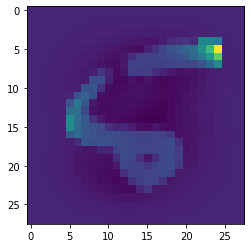

In [50]:
[plt.imshow(X_test[8,:,:,0]) for i in range(0,10)];

## Exercise 3: Fashion data set
This is similar to MNIST in size but harder to classify right.

In [51]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [52]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(55000, 28, 28, 1) (55000,)
(5000, 28, 28, 1) (5000,)
(10000, 28, 28, 1) (10000,)


In [53]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [54]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

### Filter sizes
For each layer, the size of the filters can be calculated as

$\sqrt((param-nfeatures)/nfeatures)$

Subtract nfeatures for the biases (they count as one parameter per feature) and filters are 2D $(nfilter^2)$

Example, below, 
conv2d_3  we have
sqrt((3200-64)/64)=7
conv2d_7, we have
sqrt((590080-256)/256)=48



In [55]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 256)        

In [56]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 0.7292 - accuracy: 0.7469 - val_loss: 0.3822 - val_accuracy: 0.8674
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4188 - accuracy: 0.8573 - val_loss: 0.3373 - val_accuracy: 0.8798
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3651 - accuracy: 0.8771 - val_loss: 0.2996 - val_accuracy: 0.8942
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3295 - accuracy: 0.8879 - val_loss: 0.2789 - val_accuracy: 0.8986
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3114 - accuracy: 0.8951 - val_loss: 0.2781 - val_accuracy: 0.8980
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2889 - accuracy: 0.9021 - val_loss: 0.2828 - val_accuracy: 0.9000
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2670 - accuracy: 0.9085 - val_loss: 0.3217 - val_ac

In [57]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3061 - accuracy: 0.9022


In [58]:
X_new = X_test[:8] # pretend we have new images
y_pred = model.predict(X_new)

In [59]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [60]:
print(y_pred.shape)

(8, 10)


In [61]:
print(class_names[y_pred[0,:].argmax()])

Ankle boot


In [62]:
plt.axes

<function matplotlib.pyplot.axes(arg=None, **kwargs)>

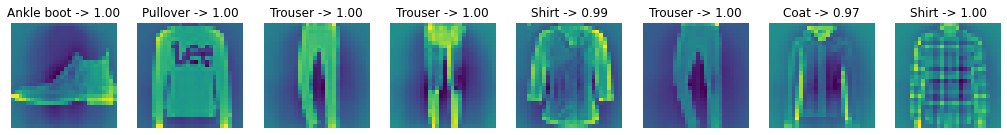

In [68]:
plt.figure(figsize=(20,20))
for i in range(8):    
    plt.subplot(191+i)
    plt.imshow(X_new[i].reshape(28,28));    
    maxp=np.argmax(y_pred[i])
    plt.title('%s -> %.2f'%(class_names[maxp],y_pred[i][maxp]))
    plt.axis("off")

In [69]:
y_pred[:3]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.0624556e-20, 0.0000000e+00, 1.7227028e-10,
        0.0000000e+00, 1.0000000e+00],
       [8.1298726e-12, 7.8625389e-27, 9.9999332e-01, 1.0246581e-20,
        9.5156160e-08, 1.0948550e-32, 6.5613654e-06, 6.9662964e-36,
        1.6301508e-20, 7.9654858e-34],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 4.6042455e-35,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)